In [69]:
from tqdm import tqdm_notebook
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
from scipy.spatial.distance import pdist, cdist
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering

from sklearn.metrics import silhouette_score, \
                            davies_bouldin_score, \
                            make_scorer

from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors, KernelDensity
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS
from sklearn.datasets import make_blobs, make_moons, make_circles, load_iris, load_digits
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.pyplot as plt
from itertools import combinations
from joblib import Parallel, delayed
from utils import filter_paths, NPR, clustering, unpack_data, project, mae_score, plot_clustering
np.random.seed(42)
from lightgbm import LGBMClassifier
from umap import UMAP

from coranking import coranking_matrix
from coranking.metrics import continuity, LCMC, trustworthiness

# Data

In [2]:
# for tax, dim in zip(['o', 'f', 'g'], [168, 258, 535]):
#     data,_ = make_blobs(n_samples=3000, n_features = 2, centers=[[0,0], 
#                                                                  [10,10], 
#                                                                  [-10,10]], cluster_std=2, random_state=42)
# #     data = MDS(n_components=dim, random_state=24, n_jobs=-1, metric=False).fit_transform(data)
# #     data = UMAP(n_components=dim, random_state=24, n_jobs=-1).fit_transform(data)

# #     data_max = data.max(0)[None,:]
# #     data_min = data.min(0)[None,:]
    
# #     data_noise = np.random.rand(n_noise_samples,dim)
# #     data_noise = data_noise * (data_max - data_min) + data_min
    
# #     data = np.concatenate([data, data_noise])
    
#     data_projected, _ = project(data, plot=True)
# #     np.save(f'./separate_datasets_proj/BLOBS_proj_{tax}', data_projected)

In [3]:
# X_iris, y_iris = load_iris(return_X_y=True)
X_digits, y_digits = load_digits(return_X_y=True)

EV_NUM 41 REC_ERROR: 1.6094665439592912


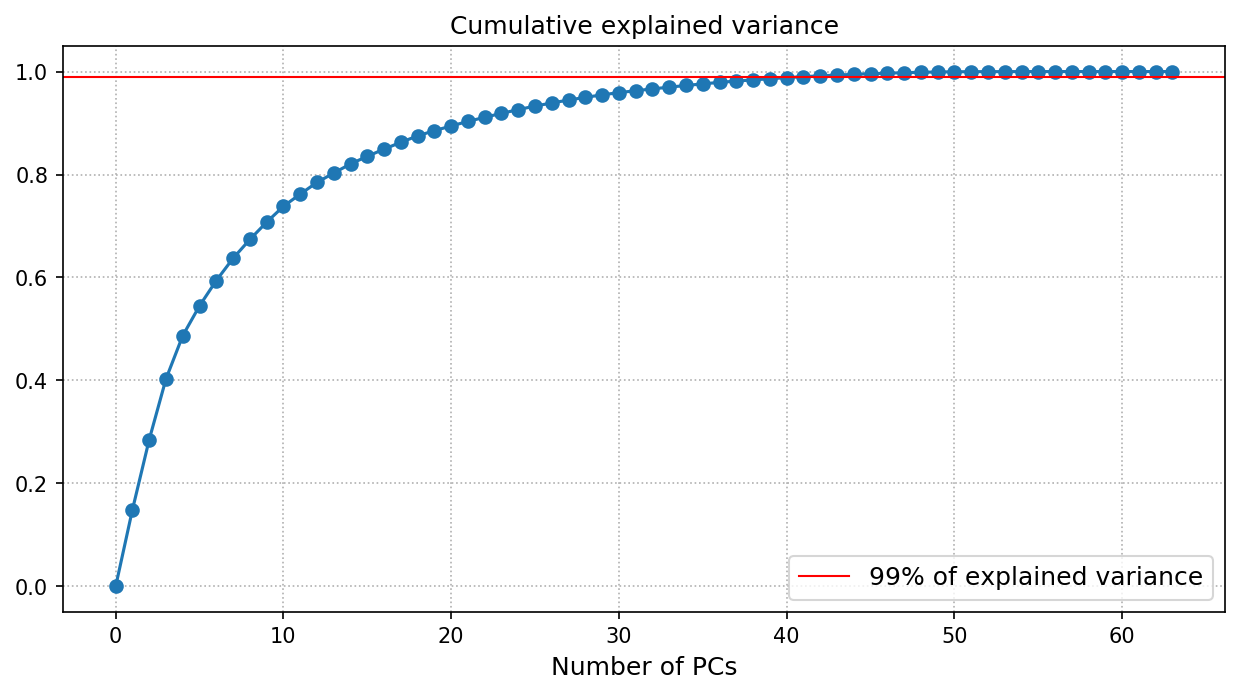

In [4]:
X_digits_projected, _ = project(X_digits, plot=True)

# Manifold learning

In [5]:
def transform(method, X, dim, parameters, scorer):
    try:
        model_inst = method(n_components=dim, **parameters, n_jobs=-1)
        Z = model_inst.fit_transform(X)
    except:
        print(f'ERROR for {parameters}')
    if np.isnan(Z).any():
        print(f'NAN for {parameters}')
        return None
    else:
        return scorer(X,Z)
    
def calculate_Q_mae(X, Z):
    
    Q = coranking_matrix(X, Z)
    
    m = X.shape[0]
    UL_cumulative = 0 
    Q_k = []
    LCMC_k = []
    for k in range(0, Q.shape[0]):
        r = Q[k:k+1,:k+1].sum()
        c = Q[:k,k:k+1].sum()
        UL_cumulative += (r+c)
        Qnk = UL_cumulative/((k+1)*m) # (k+1)
        Q_k.append(Qnk)
        LCMC_k.append(Qnk - ((k+1)/(m-1)))
    
    argmax_k = np.argmax(LCMC_k)
    k_max = np.arange(1.,m)[argmax_k]
    Q_loc = (1./k_max)*np.sum(Q_k[:argmax_k+1])
    Q_glob = (1./(m-k_max))*np.sum(Q_k[argmax_k+1:])
    
    mae = cross_validatew(X, Z)
    
    return Q_loc, Q_glob, mae

def cross_validate(X,Z):
    knn = KNeighborsRegressor()
    mo = MultiOutputRegressor(knn)
    mae_scorer = make_scorer(mae_score, greater_is_better=False)
    return -cross_val_score(mo, Z, X, scoring=mae_scorer, cv=3, n_jobs=-1).mean()

In [55]:
mf_models = {#'isomap':{'class':Isomap, 'params_grid':{'n_neighbors':[7,10,12,15,20,25,30,50],
#                                                       'p':[1,2],
#                                                       'metric':['minkowski'],
#                                                       }}
#              'lle':{'class':LocallyLinearEmbedding, 'params_grid':{'method':['ltsa','modified'],
#                                                                    'n_neighbors':[3,5,7,9,10,12,15],
#                                                                    'random_state':[42]}}
#             'umap':{'class':UMAP, 'params_grid':{'n_neighbors':[5,10,15,20,50],
#                                                  'min_dist':[0.1, 0.2, 0.3, 0.4],
#                                                  'random_state':[42],
#                                                  'metric':['euclidean','manhattan', 'canberra']}}
            'tsne':{'class':TSNE, 'params_grid':{'perplexity':[5,10,15,20,50],
                                                 'random_state':[42],
                                                 'early_exaggeration':[2,6,12,20],
                                                 'metric':['euclidean','manhattan'],
                                                 'init':['pca']
                                                 }} 
            }

scorer_Q_mae = calculate_Q_mae
results = defaultdict(dict)

# for label, X in tqdm_notebook(data_pca.items()):

for label, X in tqdm_notebook([('digits', X_digits)]):

        dim = 2
        for mf_type, model in mf_models.items():
            
            if mf_type=='lle':
                model['params_grid']['n_neighbors'] = list(filter(lambda x: x>=dim, model['params_grid']['n_neighbors']))
            
            model_class = model['class']
            model_param_grid = model['params_grid']
            results[label][mf_type] = {}
            
#             scores = Parallel(n_jobs=1)(delayed(transform)(model_class,
#                                                             X, 
#                                                             dim,
#                                                             model_params,
#                                                             scorer_Q_mae) \
#                                                             for model_params in tqdm_notebook(list(ParameterGrid(model_param_grid)))) 
            scores = []
            for model_params in  tqdm_notebook(list(ParameterGrid(model_param_grid))):
                scores.append(transform(model_class,
                                        X, 
                                        dim,
                                        model_params,
                                        scorer_Q_mae))
    

            results[label][mf_type]['scores'] = scores
            results[label][mf_type]['params'] = model_param_grid

                
# np.save('mf_learning_metrics_results', results)

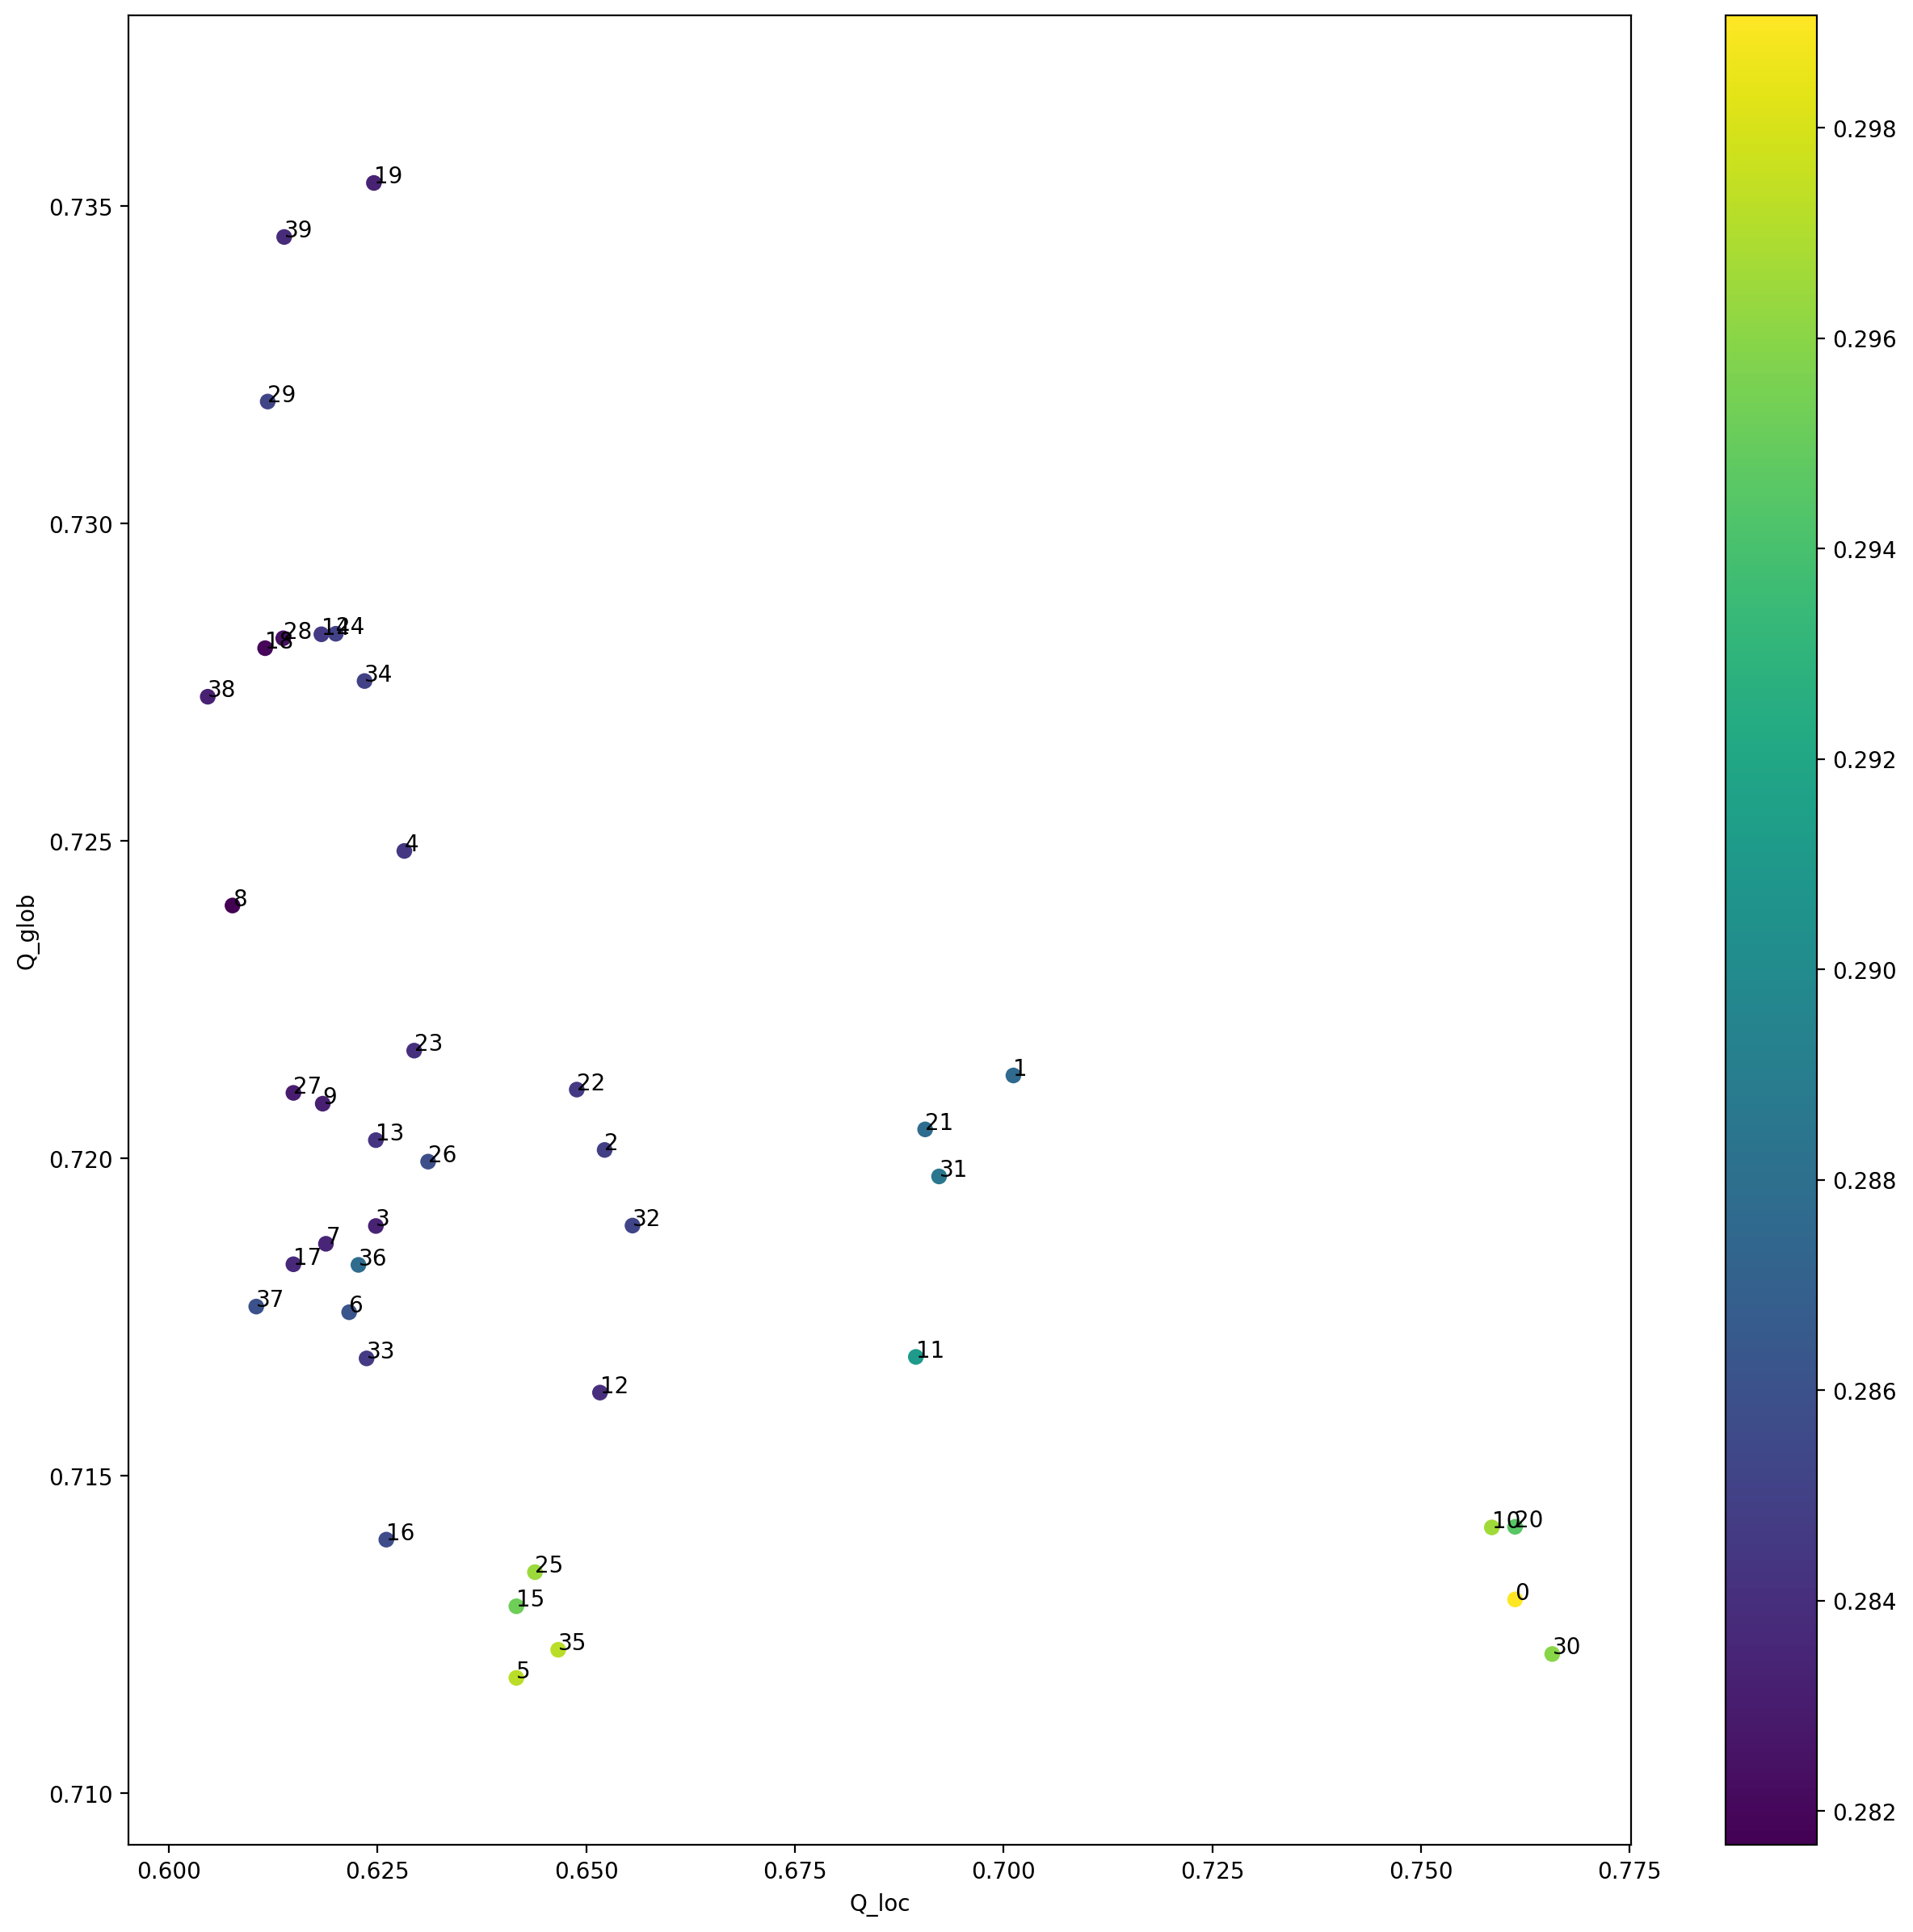

In [56]:
scores = np.array(results[label][mf_type]['scores'])
params = list(ParameterGrid(results[label][mf_type]['params']))

plt.figure(figsize=(15,15), dpi=200)
c = plt.scatter(scores[:,0], scores[:,1], c=scores[:,-1])
for txt, xy in zip(np.arange(len(scores)), scores[:,:2]):
    plt.annotate(txt, xy)
plt.xlabel('Q_loc')
plt.ylabel('Q_glob')
plt.colorbar()
plt.show()

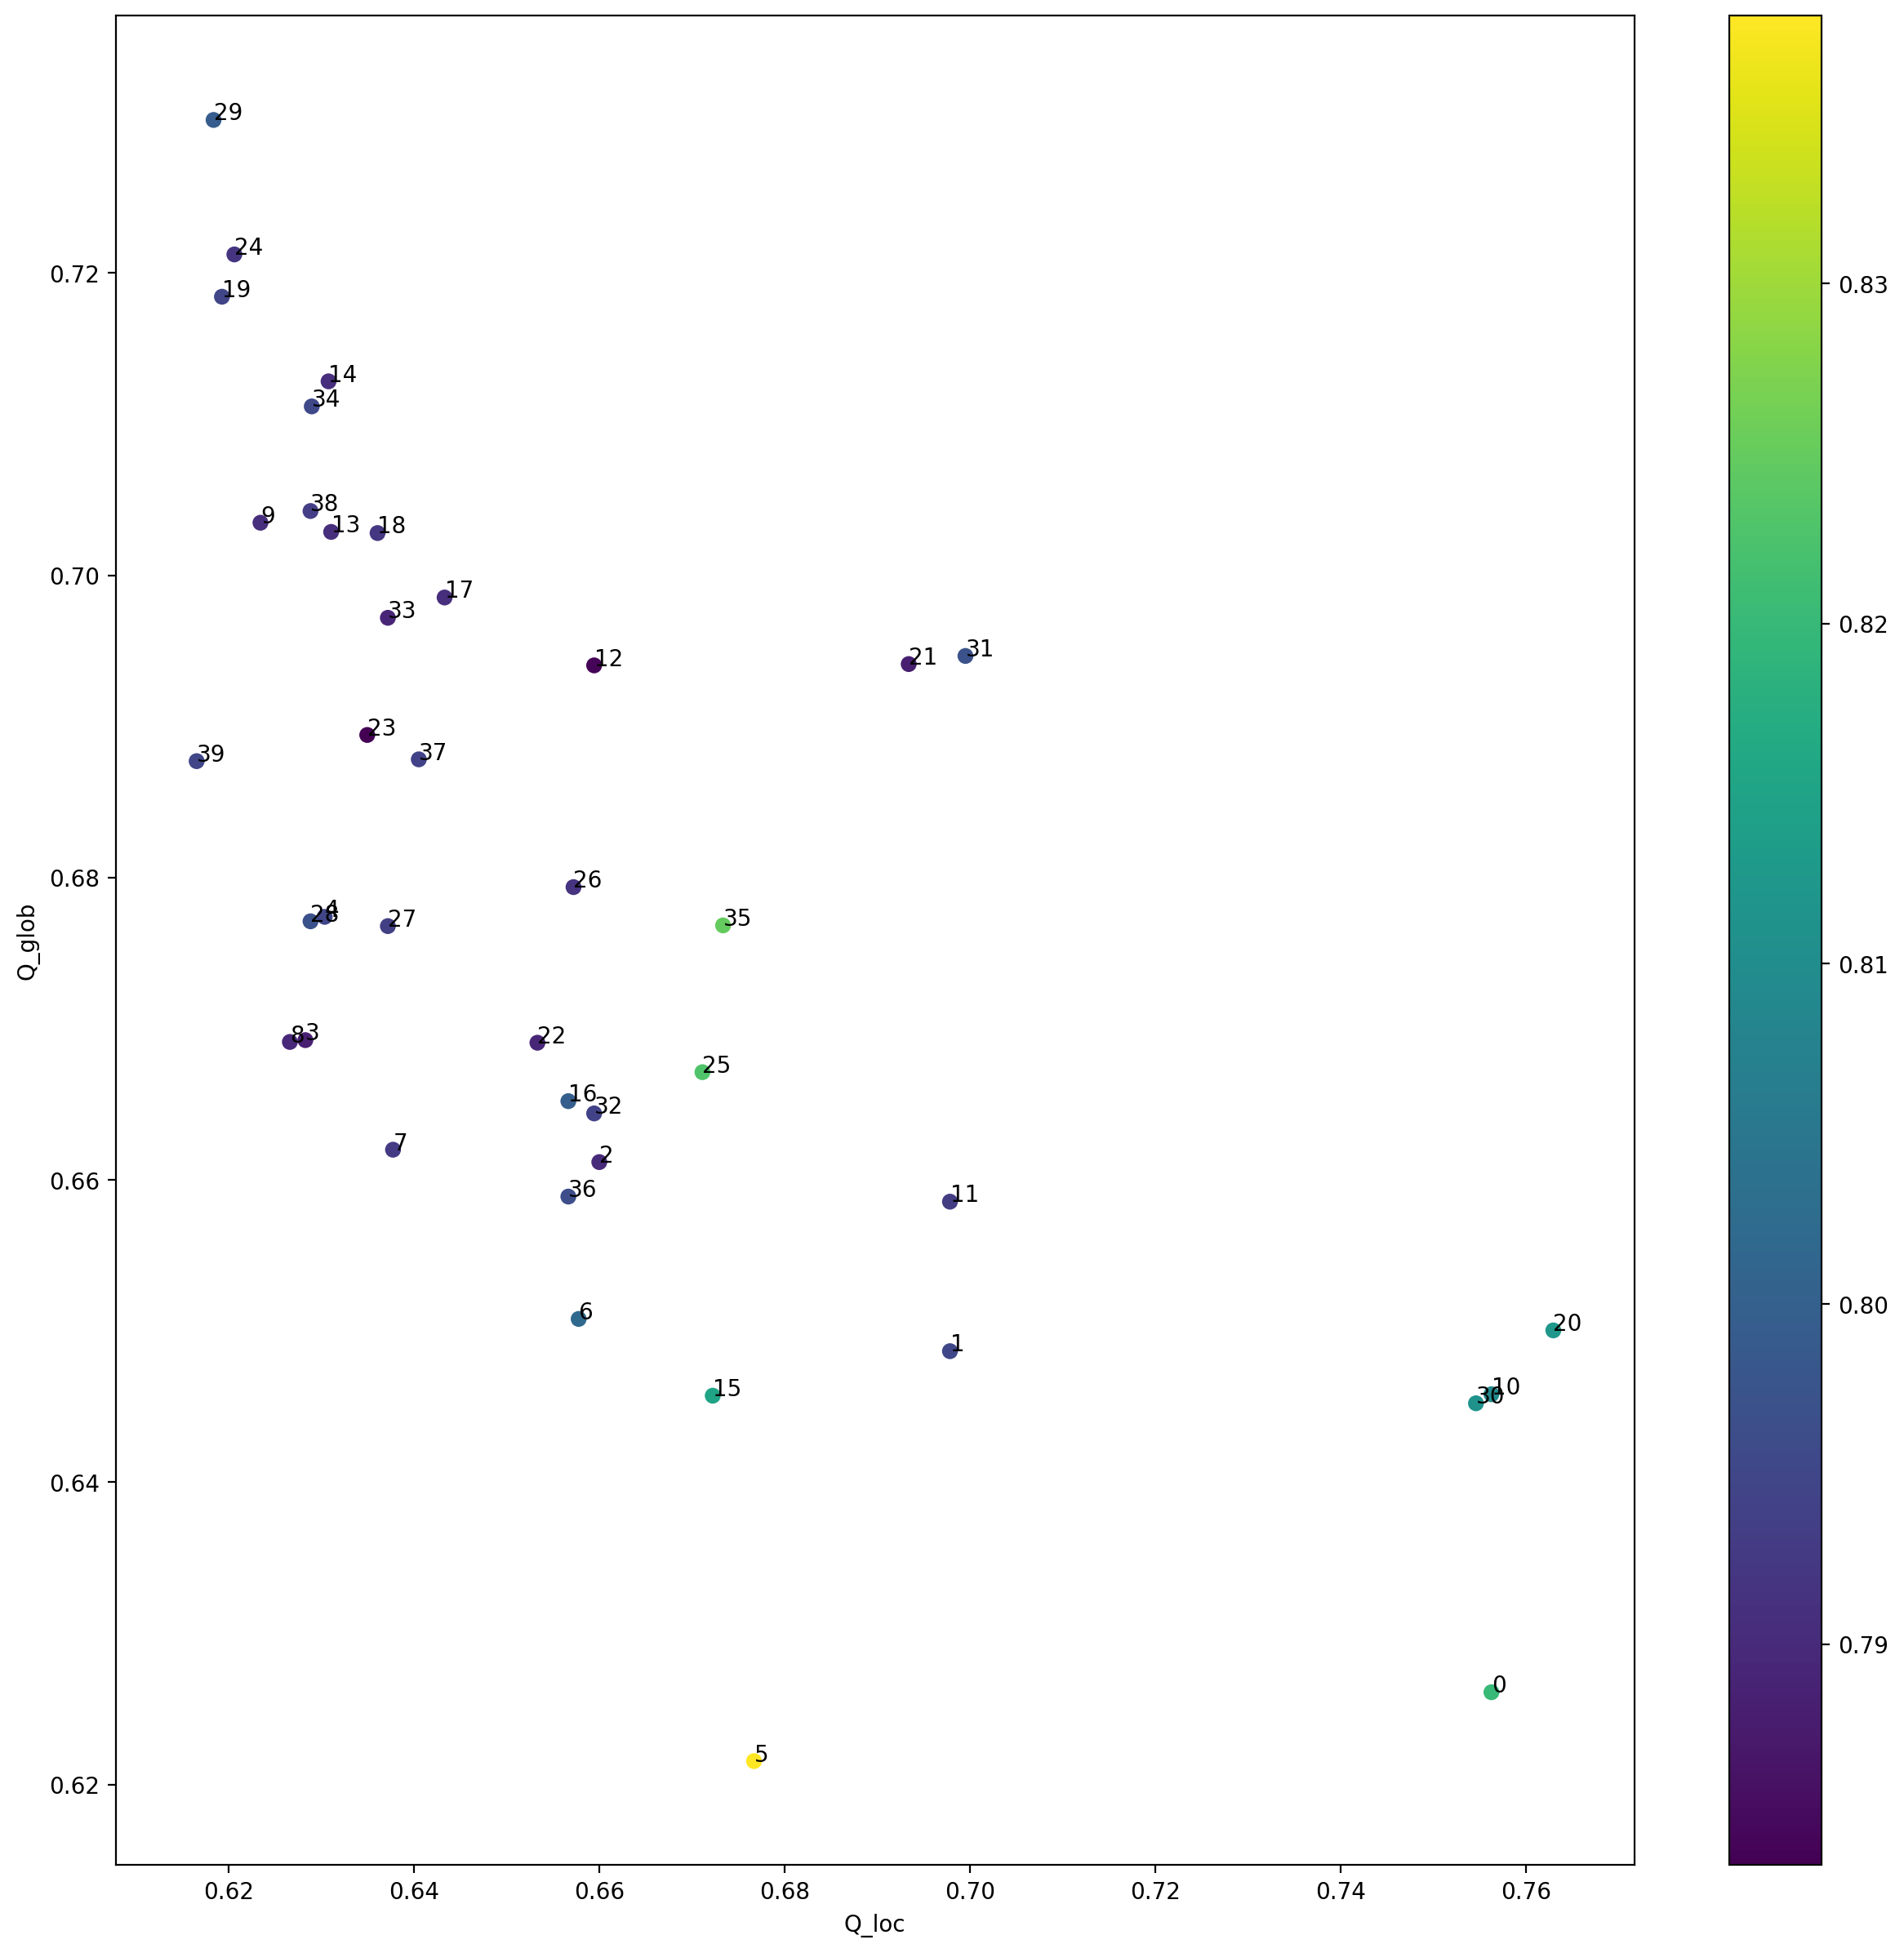

In [42]:
scores = np.array(results[label][mf_type]['scores'])
params = list(ParameterGrid(results[label][mf_type]['params']))

plt.figure(figsize=(15,15), dpi=200)
c = plt.scatter(scores[:,0], scores[:,1], c=scores[:,-1])
for txt, xy in zip(np.arange(len(scores)), scores[:,:2]):
    plt.annotate(txt, xy)
plt.xlabel('Q_loc')
plt.ylabel('Q_glob')
plt.colorbar()
plt.show()

In [87]:
# best_index = 0
# best_params = params[best_index]
# best_params, scores[best_index]

model_instance = model_class(n_components=2, init='pca', random_state=0, early_exaggeration=12)
Z = model_instance.fit_transform(X)

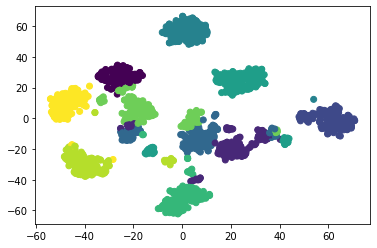

In [88]:
plt.scatter(Z[:,0], Z[:,1], c=y_pred)

In [81]:
# clustering_results, clustering_preds = clustering({'digits':Z},
#                                                    SpectralClustering,
#                                                     np.arange(2,15),
#                                                     precomputed=False,
#                                                     dbscan=False)

In [82]:
# plot_clustering(clustering_results)